In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=True)

client

/Users/edeno/miniconda3/envs/replay_trajectory_paper/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: inproc://10.49.35.109/57377/1 Dashboard: http://localhost:65334/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


In [4]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [7]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag
from replay_trajectory_classification import SortedSpikesClassifier

position = data['position_info'].linear_position
track_labels = data['position_info'].arm_name
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

In [16]:
from loren_frank_data_processing import reshape_to_segments
from loren_frank_data_processing.position import make_track_graph
from src.parameters import ANIMALS

ripple_spikes = reshape_to_segments(
    data['spikes'], data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position', 'linear_position', 'track_segment_id']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

track_graph, _ = make_track_graph(epoch_key, ANIMALS)

In [188]:
from src.analysis import get_probability, get_is_classified, get_n_unique_spiking
from src.parameters import PROBABILITY_THRESHOLD, SAMPLING_FREQUENCY, TRANSITION_TO_CATEGORY
from tqdm.auto import tqdm


def get_replay_count(discrete_diag, movement_var, place_bin_size,
                     knot_spacing, data, continuous_transition_types,
                     epoch_key, track_graph, probability_threshold=PROBABILITY_THRESHOLD):
    
    is_training = data['position_info'].speed > 4
    position = data['position_info'].loc[:, 'linear_position']
    track_labels = data['position_info'].arm_name
    
    classifier = SortedSpikesClassifier(
        place_bin_size=place_bin_size, movement_var=movement_var,
        replay_speed=1,
        discrete_transition_diag=discrete_diag,
        spike_model_penalty=0.5, knot_spacing=knot_spacing,
        continuous_transition_types=continuous_transition_types)
    classifier = classifier.fit(
        position, data['spikes'], is_training=is_training, track_labels=track_labels)

    ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
    ripple_spikes = reshape_to_segments(data['spikes'], ripple_times)
    results = []
    for ripple_number in data['ripple_times'].index:
        ripple_time = (ripple_spikes.loc[ripple_number].index -
                       ripple_spikes.loc[ripple_number].index[0])
        results.append(
            classifier.predict(ripple_spikes.loc[ripple_number],
                               time=ripple_time))
    results = (xr.concat(results, dim=data['ripple_times'].index)
               .assign_coords(state=lambda ds: ds.state.to_index()
                              .map(TRANSITION_TO_CATEGORY)))

    probability = get_probability(results)
    is_classified = (get_is_classified(probability, probability_threshold)
                     .sel(state=['continuous', 'fragmented', 'hover']))

    replay_info = (is_classified.sum('time') / data['sampling_frequency'])
    replay_info = replay_info.to_dataframe().unstack(level=1)
    replay_info.columns = list(replay_info.columns.get_level_values('state'))
    replay_info = replay_info.rename(
        columns=lambda column_name: column_name + '_duration')
    is_category = (replay_info > 0.0).rename(columns=lambda c: c.split('_')[0])
    replay_info = pd.concat((replay_info, is_category), axis=1)
    replay_info['is_classified'] = np.any(replay_info > 0.0, axis=1)
    replay_info['n_unique_spiking'] = get_n_unique_spiking(ripple_spikes)
    replay_info = replay_info.loc[replay_info.n_unique_spiking >= 3]

    return {
        'n_continuous': replay_info.continuous.sum(),
        'n_hover': replay_info.hover.sum(),
        'n_fragmented': replay_info.fragmented.sum(),
        'n_unclassified': (~replay_info.is_classified).sum(),
        'n_classified': (replay_info.is_classified).sum()
    }

In [189]:
from itertools import product

discrete_diag = [0.990, 0.999]
movement_var = [x ** 2 for x in range(1, 7)]
knot_spacing = [5, 10]
place_bin_size = range(1, 6)

parameters = list(product(discrete_diag, movement_var, place_bin_size, knot_spacing))

results = [get_replay_count(diag, var, bin_size, knot, continuous_transition_types,
                            data, epoch_key, track_graph)
           for diag, var, bin_size, knot in tqdm(parameters)]

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...
INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:

In [191]:

names = ['discrete_diag', 'random_walk_var', 'place_bin_size', 'knot_spacing']
index = pd.MultiIndex.from_product(
    (discrete_diag, movement_var, place_bin_size), names=names)
info = pd.DataFrame(results, index=index)
info

n_continuous  n_hover  \
discrete_diag random_walk_var place_bin_size                          
0.990         1               1                          1        0   
                              2                          1        0   
                              3                          0        0   
                              4                          0        0   
                              5                          0        0   
              4               1                         33        1   
                              2                         34        1   
                              3                         34        1   
                              4                         32        1   
                              5                         16        0   
              9               1                         43        3   
                              2                         44        3   
                              3                         44        3   
                              4                         45        2   
                              5                         45        2   
              16              1                         55        6   
                              2                         55        6   
                              3                         56        6   
                              4                         58        5   
                              5                         57        5   
              25              1                         60        7   
                              2                         60        7   
                              3                         61        7   
                              4                         61        8   
                              5                         62        8   
              36              1                         62        9   
                              2                         62       10   
                              3                         62       11   
                              4                         62       11   
                              5                         62       12   
0.999         1               1                          6        0   
                              2                          5        0   
                              3                          0        0   
                              4                          0        0   
                              5                          0        0   
              4               1                         44        1   
                              2                         44        1   
                              3                         44        1   
                              4                         42        1   
                              5                         36        0   
              9               1                         55        3   
                              2                         57        3   
                              3                         58        3   
                              4                         59        4   
                              5                         59        3   
              16              1                         64        6   
                              2                         64        6   
                              3                         64        6   
                              4                         65        6   
                              5                         65        6   
              25              1                         68        6   
                              2                         69        6   
                              3                         69        7   
                              4                         69        6   
                              5                         70        7   

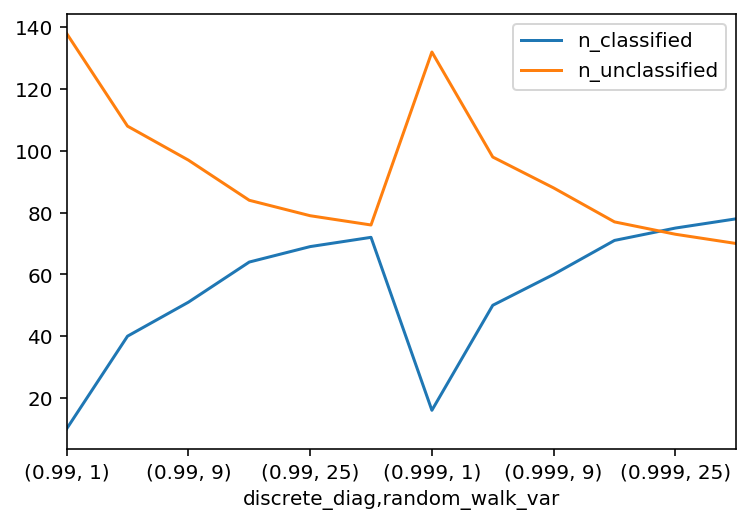

In [176]:
fig, ax = plt.subplots()
info.loc[:, ['n_classified', 'n_unclassified']].plot(ax=ax)

discrete_diag
0.990    AxesSubplot(0.125,0.125;0.775x0.755)
0.995    AxesSubplot(0.125,0.125;0.775x0.755)
0.999    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

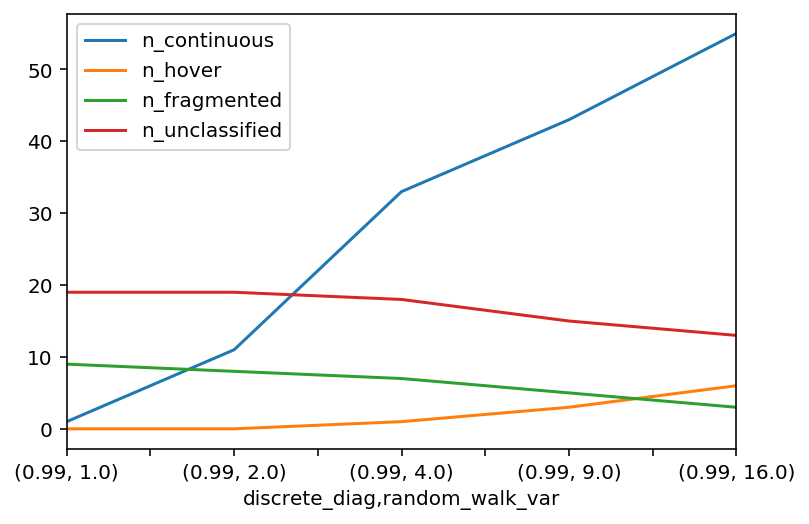

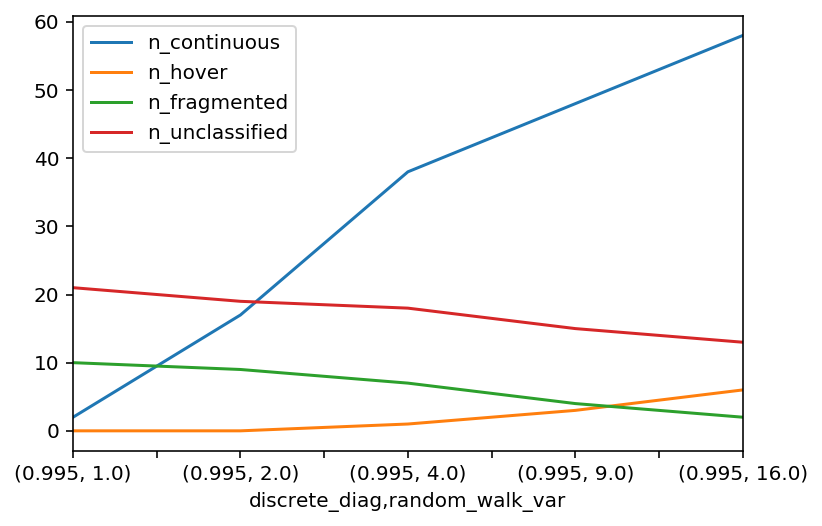

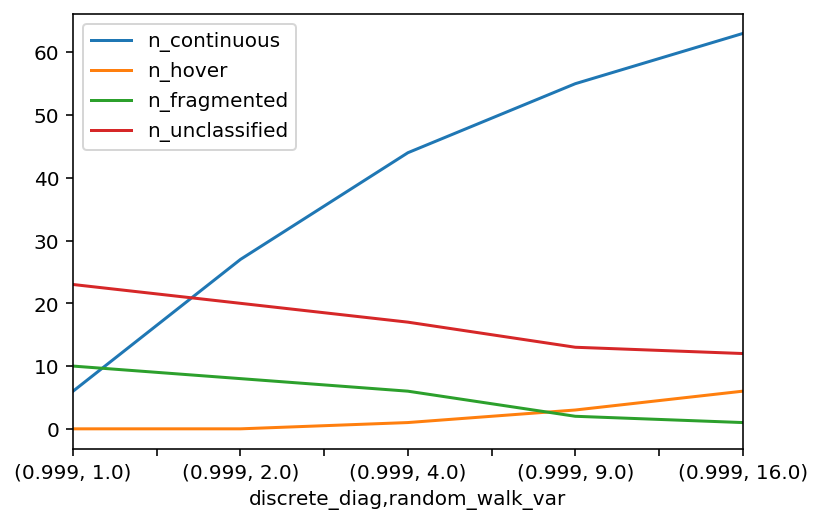

In [68]:
info.groupby('discrete_diag').plot()

In [ ]:
continuous_transition_types = (
    [['w_track_1D_random_walk_minus_identity', 'w_track_1D_inverse_random_walk', 'identity'],
     ['w_track_1D_inverse_random_walk',   'w_track_1D_inverse_random_walk', 'w_track_1D_inverse_random_walk'],
     ['w_track_1D_random_walk_minus_identity', 'w_track_1D_inverse_random_walk', 'identity']])


results = [get_replay_count(diag, var, bin_size, knot, continuous_transition_types,
                            data, epoch_key, track_graph)
           for diag, var, bin_size, knot in tqdm(parameters)]


index = pd.MultiIndex.from_product(
    (discrete_diag, movement_var, place_bin_size), names=names)
info2 = pd.DataFrame(results, index=index)
info2